# Hands-on Lab --- Churn Modeling

## Importing some standard packages, as well as packages needed for modeling:

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

## import modeling data created in the Data Prep pipeline

In [46]:
combined_df = pd.read_csv(r'C:\Users\dangt\Desktop\Trinh Phan\OSU Lesson\Fall 2020\Customer Life Time Value\Group Project\combined_data.csv')

C:\Users\dangt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Using the head method to preview our data:

In [47]:
combined_df.head()

,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,tier,tier_prev,acct_ID,activation_date,event_date,churn_year_plus1_ind,log_order_cnt_36mo,log_purch_amt_36mo,log_purch_amt_life,log_purch_avg_36mo,...,ST_VT,ST_WA,ST_WI,ST_WV,ST_WY,ST_missing,demog_LOR_imp_00 to 05 years,demog_LOR_imp_06 to 10 years,demog_LOR_imp_11 to 19 years,demog_LOR_imp_20+ years,demog_ownrent_imp_Definite Owner,demog_ownrent_imp_Definite Renter,demog_ownrent_imp_Probable Owner,demog_ownrent_imp_Probable Renter,tier_1-Bronze,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_1-Bronze,tier_prev_2-Silver,tier_prev_3-Gold,tier_prev_4-Platinum,tier_prev_5-Diamond,tier_prev_xxx
0,SC,29607,567,864,1,1,1,0,0,3,21,4.50,5,0,1,1-Bronze,xxx,I148760611,30NOV12,31MAY15,1,0.30,2.16,2.16,1.48,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
1,MO,63901,632,573,1,1,1,0,0,9,9,36.00,1,1,0,1-Bronze,xxx,I151076142,29NOV13,29NOV14,1,0.30,1.32,1.32,1.32,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,IL,60456,602,missing,0,1,1,0,0,1,167,3.07,17,0,0,1-Bronze,xxx,I27001315,05OCT00,NaN,0,0.70,2.78,3.46,1.56,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,FL,34698,539,727,1,1,1,0,0,9,13,1.00,5,1,1,3-Gold,xxx,I150064127,31JUL13,29NOV14,1,0.60,2.62,2.62,1.93,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,CA,92084,825,760,0,1,1,0,0,1,2,1.00,2,0,0,1-Bronze,xxx,I152631565,30JUN14,NaN,0,0.48,2.08,2.08,1.79,...,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1


## Doing some basic exploratory analysis:

In [48]:
""" Analyzing average values of numeric variables, by the levels of the binary target variable """
print(" ") 
print("averages by churn ind")
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['log_purch_amt_life'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['scheduled_purchase_flg'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['months_since_last_trans'].mean())

 
averages by churn ind
 
churn_year_plus1_ind
0    3.00
1    2.48
Name: log_purch_amt_life, dtype: float64
 
 
churn_year_plus1_ind
0    3.52e-01
1    4.28e-03
Name: scheduled_purchase_flg, dtype: float64
 
 
churn_year_plus1_ind
0    1.76
1    6.15
Name: months_since_last_trans, dtype: float64


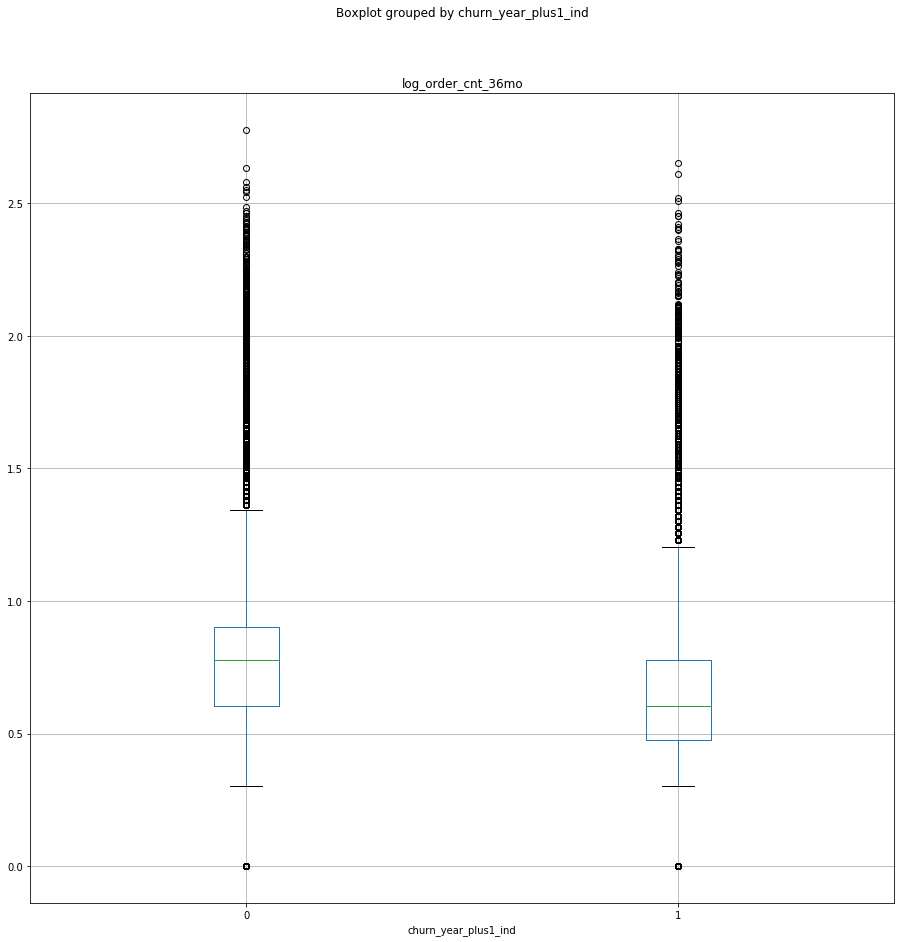

In [49]:
""" A boxplot to investigate the distribution of numeric variables by the levels of the target """

combined_df.boxplot(column='log_order_cnt_36mo', by='churn_year_plus1_ind',figsize=(15,15))

## Printing variable stats:

In [6]:
print(" summary stats on combined data ") 
print(combined_df.describe(include='all').transpose())

 summary stats on combined data 
                                     count  unique             top    freq     mean      std      min      25%      50%      75%      max
ST                                  239356      61              TX   21540      NaN      NaN      NaN      NaN      NaN      NaN      NaN
Zip                                 239356   26096         missing     889      NaN      NaN      NaN      NaN      NaN      NaN      NaN
DMA                                 239356     420             803    9523      NaN      NaN      NaN      NaN      NaN      NaN      NaN
Area_Cd                             239356     384         missing   13034      NaN      NaN      NaN      NaN      NaN      NaN      NaN
emailable                          2.4e+05     NaN             NaN     NaN     0.52      0.5        0        0        1        1        1
solicit_ph_ind                     2.4e+05     NaN             NaN     NaN     0.89     0.31        0        1        1        1        1
s

## Dropping variables we don't want included in modeling, and creating new version of data for modeling:

In [50]:
""" Any categorical variable for which we did not create dummy indicators        """
"""    and other variables we don't want in the model, or which don't make sense """
"""    to be included in model training, we are dropping here:                   """

""" Note:  we also want to drop acct_ID, but we are going to do that after partioning """
"""        because we need acct_ID for partioned sets to for reference later          """

x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date','ST','demog_ownrent_imp','demog_LOR_imp','tier','tier_prev'],axis=1)

x_train_df.shape

(239356, 121)

In [51]:
x_train_df.head()

,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,acct_ID,churn_year_plus1_ind,log_order_cnt_36mo,log_purch_amt_36mo,log_purch_amt_life,log_purch_avg_36mo,log_purch_cnt_life,log_purch_cnt_tt_36mo,log_resp_cnt_36mo,perc_purch_cc_36mo,perc_purch_ck_36mo,perc_purch_et_36mo,margin_Y_neg_1,margin_Y_neg_2,...,ST_VT,ST_WA,ST_WI,ST_WV,ST_WY,ST_missing,demog_LOR_imp_00 to 05 years,demog_LOR_imp_06 to 10 years,demog_LOR_imp_11 to 19 years,demog_LOR_imp_20+ years,demog_ownrent_imp_Definite Owner,demog_ownrent_imp_Definite Renter,demog_ownrent_imp_Probable Owner,demog_ownrent_imp_Probable Renter,tier_1-Bronze,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_1-Bronze,tier_prev_2-Silver,tier_prev_3-Gold,tier_prev_4-Platinum,tier_prev_5-Diamond,tier_prev_xxx
0,1,1,1,0,0,3,21,4.50,5,0,1,I148760611,1,0.30,2.16,2.16,1.48,0.78,0.78,0.00,0.8,0.2,0.0,5.22,112.05,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
1,1,1,1,0,0,9,9,36.00,1,1,0,I151076142,1,0.30,1.32,1.32,1.32,0.30,0.30,0.00,0.0,1.0,0.0,4.09,0.00,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,0,1,1,0,0,1,167,3.07,17,0,0,I27001315,0,0.70,2.78,3.46,1.56,2.01,1.26,0.48,0.0,1.0,0.0,342.10,81.59,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,1,1,1,0,0,9,13,1.00,5,1,1,I150064127,1,0.60,2.62,2.62,1.93,0.78,0.78,0.00,1.0,0.0,0.0,311.11,74.41,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0,1,1,0,0,1,2,1.00,2,0,0,I152631565,0,0.48,2.08,2.08,1.79,0.48,0.48,0.00,0.5,0.5,0.0,115.14,0.00,...,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1


# Partitioning data into Training and Test sets, creating X vs Y sets, and
##     creating dataframes with just account IDs to be used to rejoin data later:

In [52]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30, random_state= 42)

""" will need the acct_IDs to rejoin data later, so pulling out now before dropping from actual model training data """

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]

""" the target (or dependent) variable is stored in it's own dataframe """

y_train_df = x_train_df[['churn_year_plus1_ind']]
y_test_df  = x_test_df[['churn_year_plus1_ind']]

""" and we want to drop acct_ID and the target variable from the dataframe of independent variables """
""" PLUS we want to drop the target (future timeframe) variables for margin modeling                """

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_train_df.shape

(167549, 117)

## Starting with a scikit_learn Logistic Regression Model
##    and using that modeling algorithm to select variables.

## Note:  change the C parameter and rerun to get reasonable number of selected vars.

In [53]:
""" models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero """
""" SelectFromModel can be used to to select effects with non-zero coefficients """
""" the parameter C controls the sparsity: the smaller C the fewer features selected """

""" using the ravel simply to avoid warning in log """
y_train_array=np.ravel(y_train_df)

""" start with C = 1.0, then try 0.1, then 0.01 """
model1 = linear_model.LogisticRegression(C = 0.01, solver='liblinear', penalty='l1', tol=0.01)
model1_fit = model1.fit(x_train_df, y_train_array)
model1_selects = SelectFromModel(model1_fit, prefit=True)
"""x_train_selected_df = model1_selects.transform(x_train_df)"""

""" in lieu of commented-out transform method above, can use this method to explicitly define columns to keep """
x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]

coefficients = pd.DataFrame(model1_fit.coef_)
coefficients = np.transpose(coefficients[coefficients.columns[model1_selects.get_support()]])
coefficients = coefficients.reset_index(drop=True)

coefficients_match = pd.concat([pd.DataFrame(x_train_selected_df.columns),coefficients], axis = 1)
coefficients.shape 


(38, 1)

In [54]:
print(" ") 
print("Coefficients for selected variables")
coefficients_match.head(40)

 
Coefficients for selected variables


,0,0
0,emailable,-1.79e-01
1,solicit_ph_ind,-1.16e-02
2,solicit_email_ind,-1.12e-01
3,fixd_incm_flg,-2.17e-02
4,scheduled_purchase_flg,-4.36e+00
5,months_since_last_trans,4.33e-01
6,months_since_first_trans,-3.63e-03
7,purch_avg_interval,3.48e-03
8,mail_cnt_36mo,-1.17e-02
9,call_in_mo_36mo,-1.01e-03


## Need to introduce variable reduction that addresses multicolinearity:

In [55]:
x_train_selected_df.shape

(167549, 38)

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
        else:
            dropped=False
    print('Remaining variables:')
    print(X.columns[variables])        
        
    return X.iloc[:, variables]

x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape

C:\Users\dangt\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'margin_Y_neg_1' at index: 20
dropping 'log_margin_3yr_avg' at index: 26
dropping 'log_margin_Y_neg_2' at index: 24
dropping 'log_margin_Y_neg_1' at index: 23
dropping 'log_margin_Y_neg_3' at index: 23
dropping 'log_purch_amt_life' at index: 13
dropping 'log_purch_amt_36mo' at index: 12
dropping 'perc_purch_ck_36mo' at index: 16
dropping 'log_purch_cnt_life' at index: 13
dropping 'solicit_email_ind' at index: 2
dropping 'margin_3yr_avg' at index: 17
dropping 'log_purch_avg_36mo' at index: 11
dropping 'demog_age_num_imp' at index: 18
dropping 'demog_ownrent_imp_Definite Owner' at index: 21
dropping 'tier_prev_xxx' at index: 23
dropping 'log_order_cnt_36mo' at index: 10
Remaining variables:
Index(['emailable', 'solicit_ph_ind', 'fixd_incm_flg', 'scheduled_purchase_flg', 'months_since_last_trans', 'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo', 'call_in_mo_36mo', 'call_out_mo_36mo', 'log_resp_cnt_36mo', 'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_

(167549, 22)

## Reducing test set to match train set.

In [57]:
""" reducing the test set to have the same columns as the training set """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]
print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['emailable', 'solicit_ph_ind', 'fixd_incm_flg', 'scheduled_purchase_flg', 'months_since_last_trans', 'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo', 'call_in_mo_36mo', 'call_out_mo_36mo', 'log_resp_cnt_36mo', 'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_2', 'margin_Y_neg_3', 'demog_generations_imp', 'demog_adults_imp', 'demog_LOR_imp_06 to 10 years', 'demog_LOR_imp_11 to 19 years', 'demog_LOR_imp_20+ years', 'tier_1-Bronze', 'tier_prev_1-Bronze'], dtype='object')


(71807, 22)

## Using the statsmodels package to see "friendlier" looking Logistic output:

In [58]:
""" for the statsmodels, need to add a constant to fit intercept """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

""" modeling with selected variables from steps above """

model = sm.Logit(y_train_df, x_train_selected_df)
result = model.fit(maxiter=100)

print(" ") 
print("Logistic model with selected variables")
print(" ") 
print(result.summary2())
print('AIC: ', result.aic)
print('BIC: ', result.bic)

Optimization terminated successfully.
         Current function value: 0.318389
         Iterations 10
 
Logistic model with selected variables
 
                               Results: Logit
Model:                 Logit                  Pseudo R-squared:   0.447      
Dependent Variable:    churn_year_plus1_ind   AIC:                106737.3900
Date:                  2020-10-08 13:50       BIC:                106968.0577
No. Observations:      167549                 Log-Likelihood:     -53346.    
Df Model:              22                     LL-Null:            -96520.    
Df Residuals:          167526                 LLR p-value:        0.0000     
Converged:             1.0000                 Scale:              1.0000     
No. Iterations:        10.0000                                               
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------

## Using the statsmodels Logit model to score the data and evaluate goodness-of-fit:

AROC train:  0.9188205415886228
AROC test:  0.9188133582502306
 
MSE train: 0.10012855208795188
MSE test: 0.10082916997288648
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.10012855208795232
mean squared error testn: 0.10082916997288735


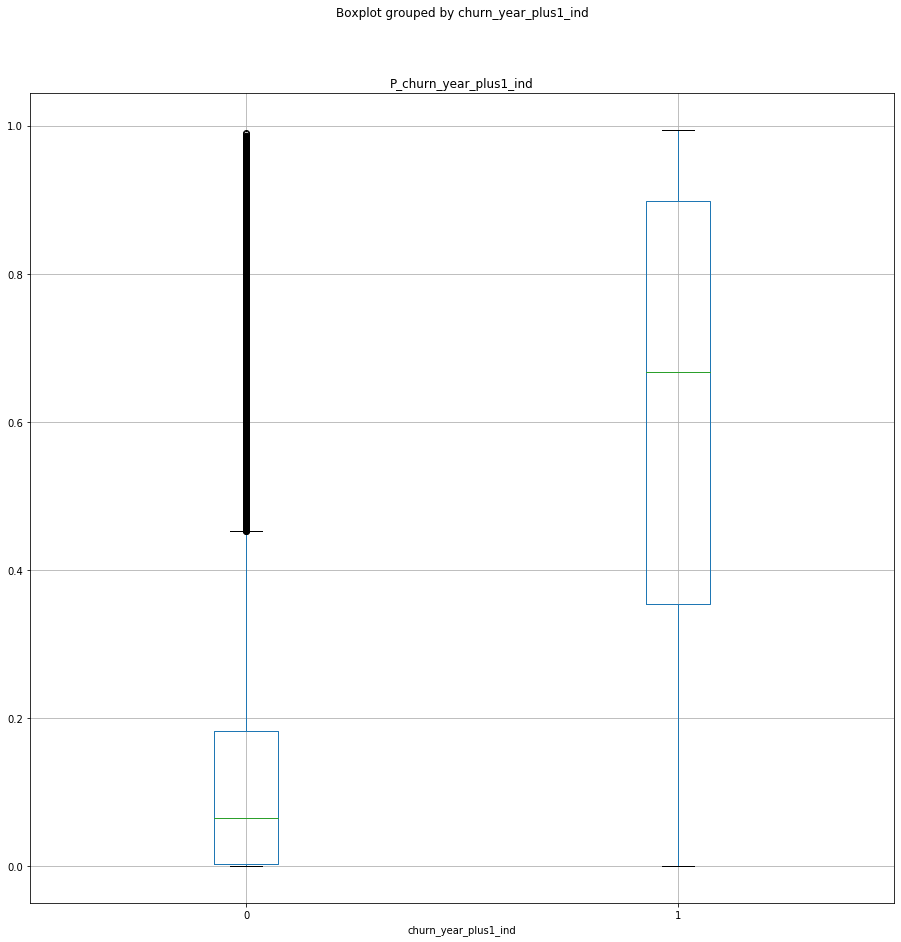

In [59]:
""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """
train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error testn:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))

pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

## Now to try a more advanced Machine Learning algorithm to see if we can get a better model.
>## If you run this first with n_estimators=500 (500 iterations) and learning_rate = 0.01...
>## we'll get a model that does well on the test set.
## Discussion:  overfitting
>## Just before a break, we'll change these settings to n_estimators=1000 and learning_rate=0.1...
>## rerun, see some degradation in the model performance on the test set.  

GB overall accuracy: 0.8784241090701463
AROC train:  0.9430166637209225
AROC test:  0.9374605841114091
 
MSE train: 0.08321535265362258
MSE test: 0.08718206342365831
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.08321535265362161
mean squared error test: 0.08718206342365863


Text(0, 0.5, 'AROC')

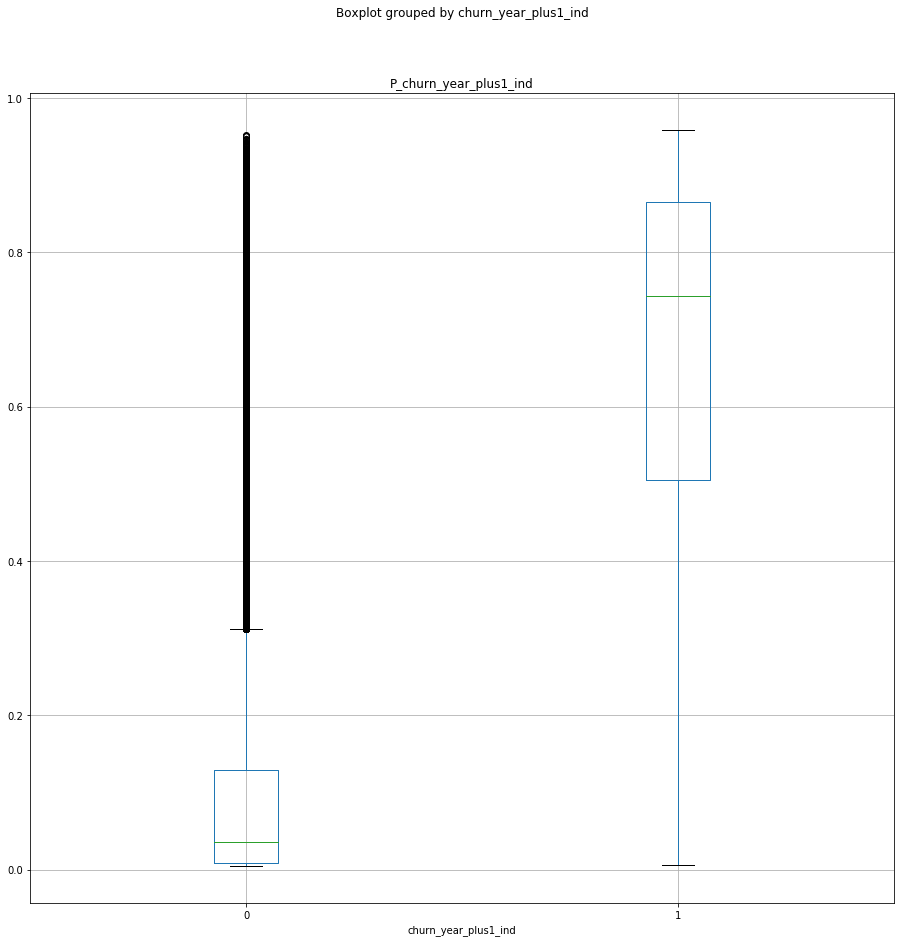

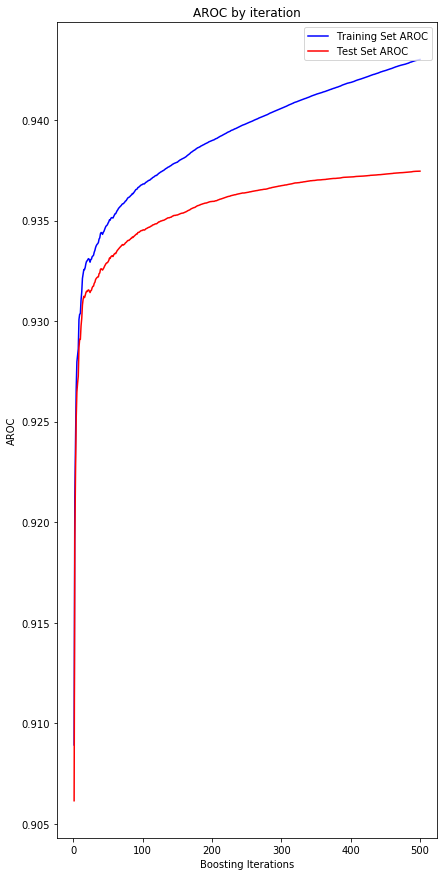

In [60]:
""" Gradient Boosting """

# setting some parameters
# n_estimators = number of iterations
# min_samples_split should be ~0.5-1% of record count?
# min_samples_leaf can be selected based on intuition. 
# max_depth = 8 should be chosen (5-8) based on the number of observations and predictors. 
# max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
# subsample = 0.8 : This is a commonly used used start value.
    
params = {'n_estimators': 500, 'learning_rate':0.01, 'min_samples_split':100, 'min_samples_leaf':10, 'max_depth':8, 'max_features':'sqrt','subsample':0.8,'random_state':10}

model2 = GradientBoostingClassifier(**params)

""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result = model2.fit(x_train_selected_df, y_train_array)

""" returns overall accuracy"""
accuracy = model2.score(x_test_selected_df, y_test_df)
print("GB overall accuracy:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model2.predict_proba(x_train_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(model2.predict_proba(x_test_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)


test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error test:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))


pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

""" plotting AROC with each iteration of the Gradient Boosting algorithm """

""" converting Y dataframes into arrays as needed for logic below """
y_traint_array = y_train_df.values
y_test_array = y_test_df.values

test_AROC  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_AROC = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model2.staged_predict_proba(x_test_selected_df)):
    test_AROC[i] = metrics.roc_auc_score(y_test_array, y_pred[:, 1])

for i, y_pred in enumerate(model2.staged_predict_proba(x_train_selected_df)):
    train_AROC[i] = metrics.roc_auc_score(y_train_array, y_pred[:, 1])

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('AROC by iteration')
plt.plot(np.arange(params['n_estimators']) + 1, train_AROC, 'b-',
         label='Training Set AROC')
plt.plot(np.arange(params['n_estimators']) + 1, test_AROC, 'r-',
         label='Test Set AROC')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('AROC')


## Feature Importance for the Gradient Boosting Model:

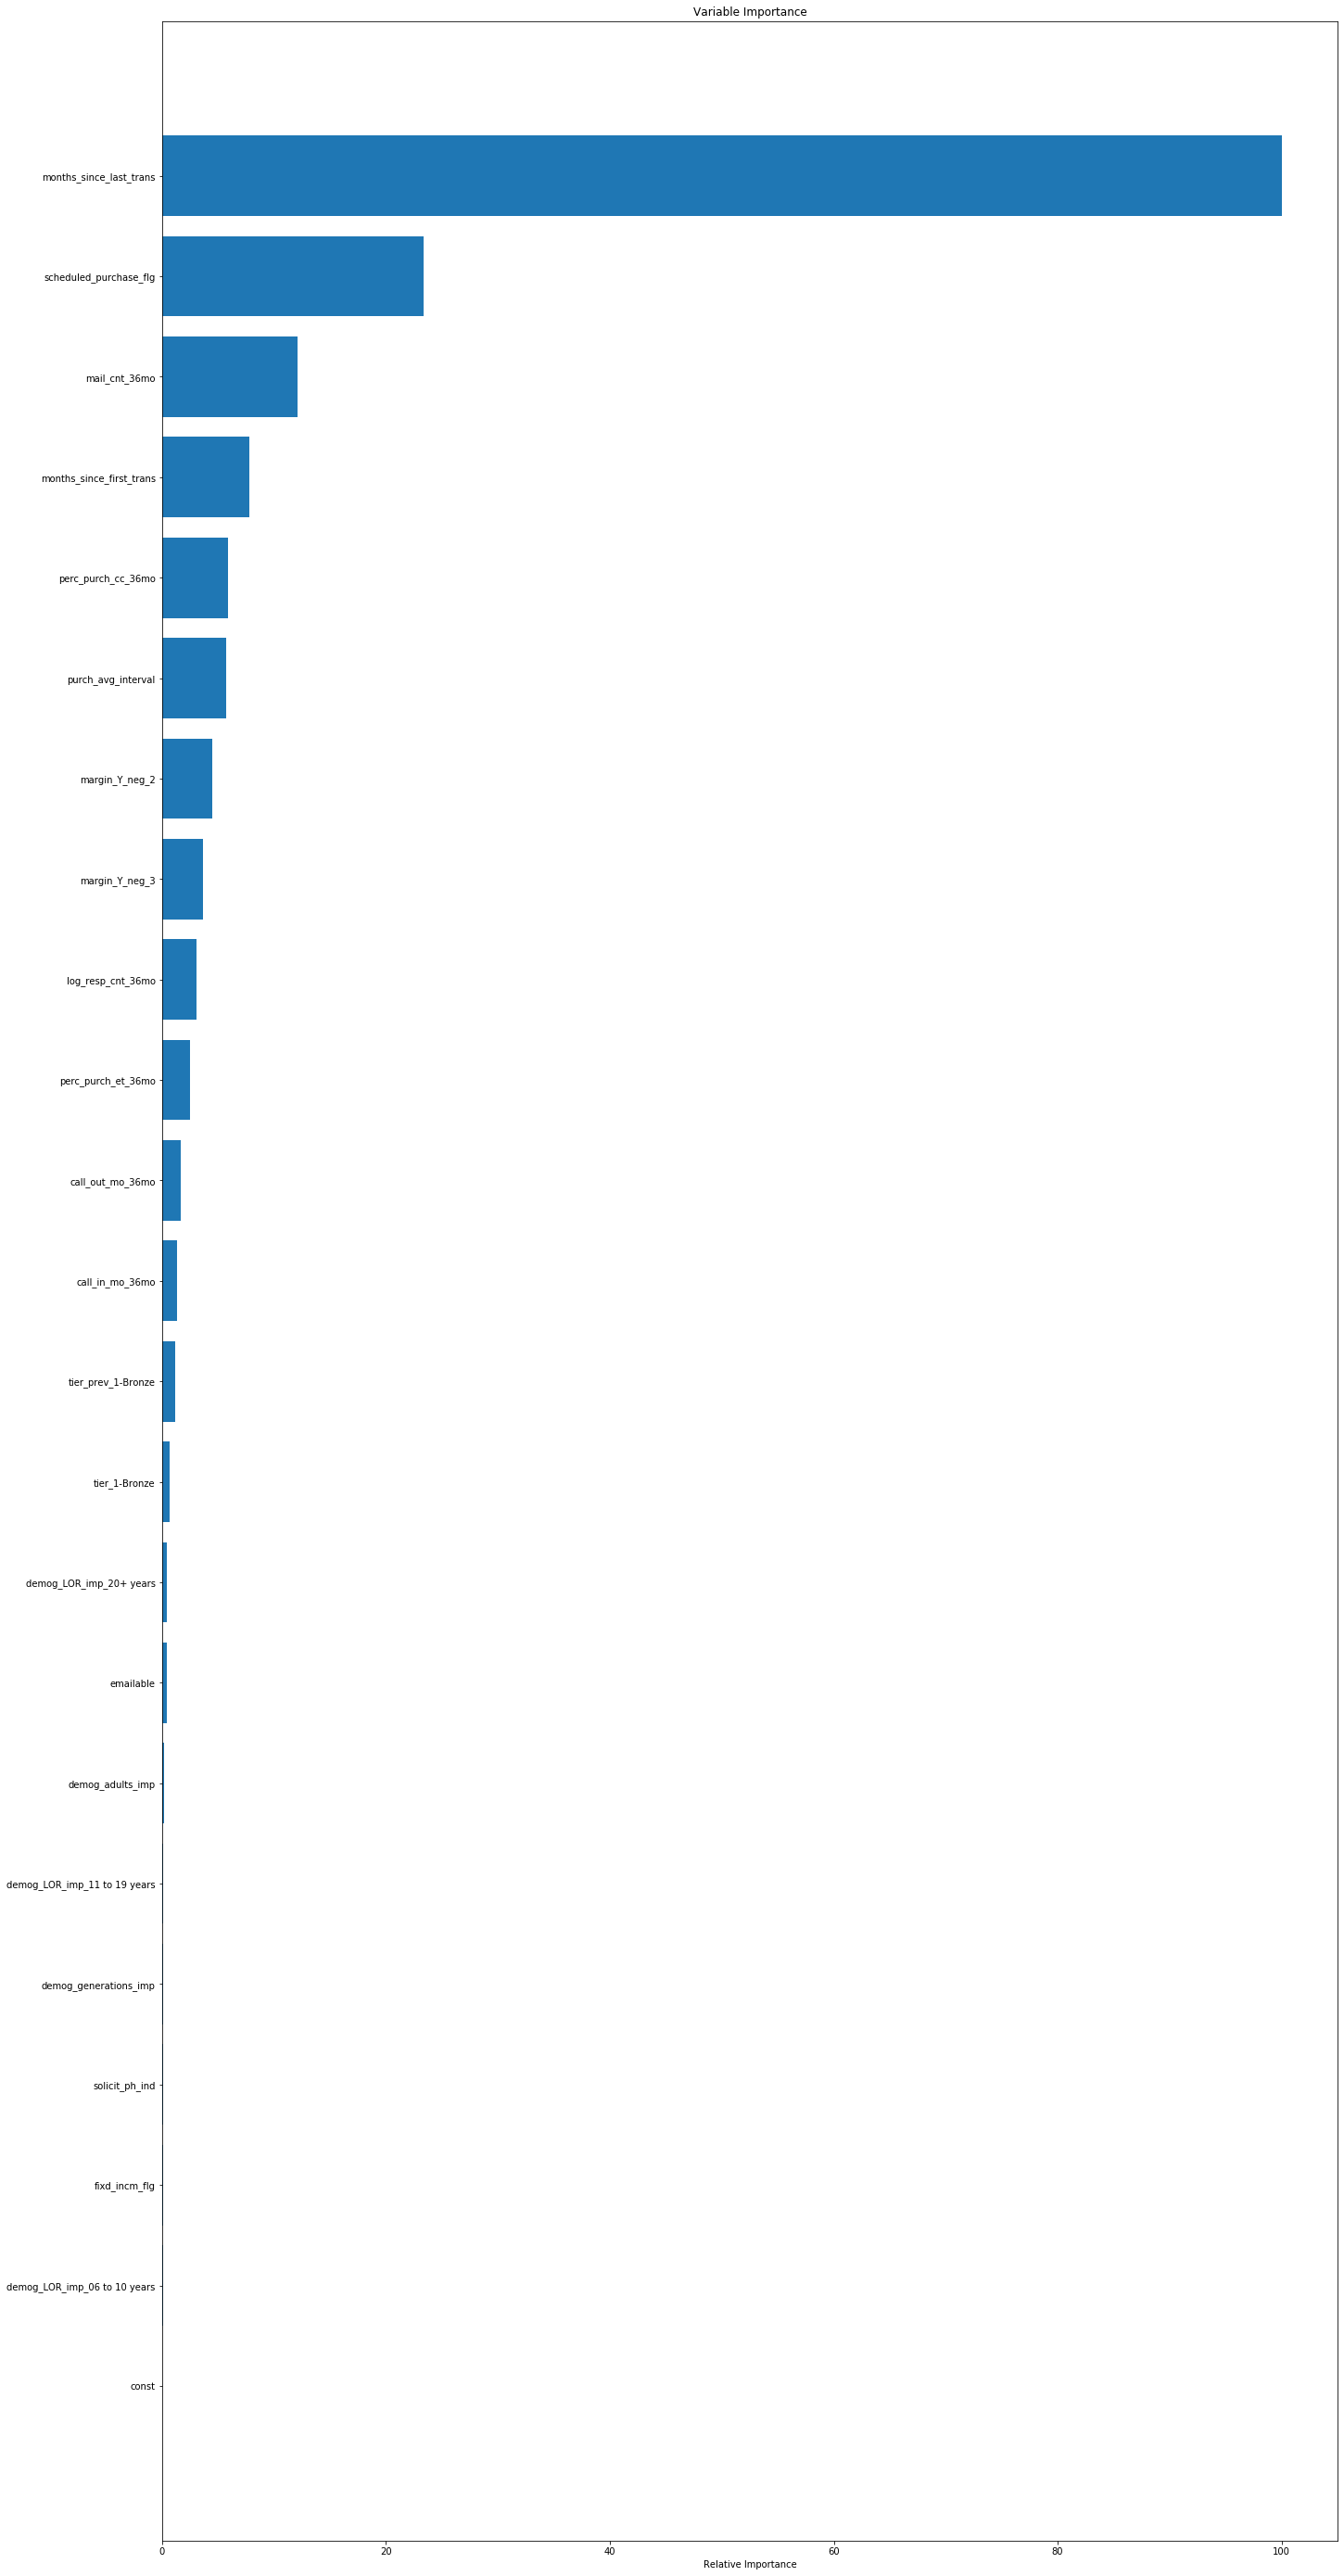

In [61]:
feature_importance = model2.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Appending the train and test sets, and keeping the acct_IDs and predicted churn probabilities

In [63]:
""" append together train and test predicted values, keeping only acct ID and predicted values """

pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_test, ignore_index=True)

pred_v_actual_train = pred_v_actual_train.drop(['churn_year_plus1_ind'],axis=1)

""" and then save predicted values by acct ID to csv """

pred_v_actual_train.to_csv(r'C:\Users\dangt\Desktop\Trinh Phan\OSU Lesson\Fall 2020\Customer Life Time Value\Group Project\churn_scores.csv',index=False)
pred_v_actual_train.shape

(311163, 2)

## (back to lecture mode)